In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import bisect
import functools
import io
import itertools
import math

from matplotlib import pyplot as plt

import numpy as np
import pandas as pd

import tensorflow as tf
from sklearn.metrics import roc_auc_score, accuracy_score, classification_report

In [3]:
tf.logging.set_verbosity(tf.logging.ERROR)
tf.set_random_seed(1)

In [4]:
LARGE = 100000

### Load data

In [5]:
# download data
train_url = 'https://download.mlcc.google.com/mledu-datasets/sparse-data-embedding/train.tfrecord'
train_path = tf.keras.utils.get_file(train_url.split('/')[-1], train_url)
test_url = 'https://download.mlcc.google.com/mledu-datasets/sparse-data-embedding/test.tfrecord'
test_path = tf.keras.utils.get_file(test_url.split('/')[-1], test_url)

In [6]:
# download the vocabulary file.
terms_url = 'https://download.mlcc.google.com/mledu-datasets/sparse-data-embedding/terms.txt'
terms_path = tf.keras.utils.get_file(terms_url.split('/')[-1], terms_url)

vocab = None
with io.open(terms_path, 'r', encoding='utf8') as f:
    vocab = list(set(f.read().split()))

vocab.sort()

In [7]:
# load data
def parse_fn(record):
    features = {
        "terms": tf.VarLenFeature(dtype=tf.string),
        "labels": tf.FixedLenFeature(shape=[1], dtype=tf.float32)
    }
  
    parsed_features = tf.parse_single_example(record, features)

    terms = parsed_features['terms'].values
    labels = parsed_features['labels']

    return  terms, labels


filenames = tf.placeholder(tf.string, shape=[None])
ds = tf.data.TFRecordDataset(filenames)
ds = ds.map(parse_fn)
ds = ds.padded_batch(LARGE, ds.output_shapes)
ds_iter = ds.make_initializable_iterator()

with tf.Session() as sess:
    sess.run(ds_iter.initializer, feed_dict={filenames: [train_path]})
    x_train, y_train = sess.run(ds_iter.get_next())

    sess.run(ds_iter.initializer, feed_dict={filenames: [test_path]})
    x_test, y_test = sess.run(ds_iter.get_next())

### Process data

Specifically need to replace each word with a vocabulary index; pad with '-1' so not jagged

In [8]:
# process the data
@functools.lru_cache(maxsize=None, typed=False)
def get_word_index(word):
    i = bisect.bisect_left(vocab, word)
    if i != len(vocab) and vocab[i] == word:
        return i

    
def convert_words_to_index(words):
    idx = []
    for word in words:
        if word == b'':
            continue
        i = get_word_index(word.decode('utf-8'))
        if i:
            idx.append(i)
    idx += [-1] * (len(words) - len(idx))
    return idx


x_train = np.array([convert_words_to_index(words) for words in x_train])
x_test = np.array([convert_words_to_index(words) for words in x_test])

### Build graph

In [9]:
VOCAB_SIZE = len(vocab)
EMBED_SIZE = 20

x = tf.sparse_placeholder(tf.int32)
y = tf.placeholder(tf.int32, shape=[None, 1])

is_train = tf.placeholder_with_default(True, shape=())
learning_rate = tf.placeholder_with_default(0.1, shape=())

embed_matrix = tf.get_variable('embed_matrix', 
                               shape=[VOCAB_SIZE, EMBED_SIZE],
                               initializer=tf.truncated_normal_initializer(0, 1/math.sqrt(EMBED_SIZE)))

embed = tf.nn.embedding_lookup_sparse(embed_matrix, x, None, name='embedding')

linear1 = tf.layers.dense(embed, units=10, activation=tf.nn.leaky_relu)
dropout = tf.layers.dropout(linear1, rate=tf.cond(is_train, lambda: 0.5, lambda: 0.0))
linear2 = tf.layers.dense(dropout, units=10)
logits = tf.layers.dense(linear2, units=2)

pred_class = tf.argmax(logits, 1)
pred_prob = tf.nn.log_softmax(logits)

loss = tf.losses.sparse_softmax_cross_entropy(labels=y, logits=logits)

optimizer = tf.train.AdagradOptimizer(learning_rate=learning_rate)
optimizer = tf.contrib.estimator.clip_gradients_by_norm(optimizer, 5.0)

train_op = optimizer.minimize(loss)

### Some functions for tuning

In [10]:
# converts numpy array to sparse tensor
def np_to_sparse_tensor(arr, null_idx=-1):
    idx  = np.where(arr != null_idx)
    return tf.SparseTensorValue(np.vstack(idx).T, arr[idx], arr.shape)


train_args = {x: np_to_sparse_tensor(x_train), y: y_train, is_train: False}
test_args = {x: np_to_sparse_tensor(x_test), y: y_test, is_train: False}

In [11]:
# construct inputs
def input_fn(x, y, batch_size=1, shuffle=True, num_epoch=None):    
    ds = tf.data.Dataset.from_tensor_slices((x, y))

    if shuffle:
        ds = ds.shuffle(buffer_size=LARGE)
    
    ds = ds.repeat(num_epoch).batch(batch_size)
    return ds.make_one_shot_iterator().get_next()

In [12]:
# train graph with a given dataset
def run(ds_iter, lr_gen, stats_callback, skip_step=None):
    sess = tf.Session()

    var_init = tf.global_variables_initializer()
    sess.run(var_init)

    stats = []
    step = 1
    while True:
        try:
            xi_train, yi_train = sess.run(ds_iter)
            lr = lr_gen.__next__()
            
            if skip_step is None:
                skip_step = 1000 // len(yi_train)
            
            sess.run(train_op, feed_dict={x: np_to_sparse_tensor(xi_train), y: yi_train, learning_rate: lr})

            if (step % skip_step) == 0:
                continue_train = stats_callback(sess, stats, step // skip_step, lr)
                if not continue_train:
                    break

            step += 1
        except tf.errors.OutOfRangeError:
            break

    return sess, stats

### Tune learning rate

Learning rate is increased on log scale until loss stops improving

In [13]:
# # tune with exponentially increasing learning rates
# start_lr = 1e-3
# end_lr = 10
# batch_size = 1
# num_epoch = 3
# num_batch = math.ceil(len(y_train)*num_epoch/batch_size)
# multiplier = (end_lr/start_lr)**(1/(num_batch-1))


# def lr_fn(start, multiplier):
#     for i in itertools.count():
#         yield start*multiplier**i


# def stats_fn(sess, stats, step, lr):
#     train_loss = sess.run(loss, feed_dict=train_args)
#     stats.append([lr, train_loss])
#     return (train_loss < 2*np.array(stats).min(axis=0)[1])


# train_iter = input_fn(x_train, y_train, batch_size=batch_size, shuffle=True, num_epoch=num_epoch)
# lr_iter = lr_fn(start_lr, multiplier)
# _, lr_stats = run(train_iter, lr_iter, stats_fn)

In [14]:
# lr_stats = np.array(lr_stats)
# plt.ylabel('Loss')
# plt.xlabel('Learning Rate')
# plt.title('Learning Rate vs. Loss')
# plt.tight_layout()
# plt.plot(lr_stats[:, 0], lr_stats[:, 1])
# plt.xscale('log')
# plt.yscale('log')
# plt.show()

### Train model

Use cyclical cosine annealing to periodically decrease learning rate over time

In [15]:
start_lr = 0.1
end_lr = 0.01
batch_size = 10
cycle_len = 1 # length in epochs
num_batch_per_cycle = math.ceil(len(y_train)*cycle_len/batch_size)


def lr_fn(start, end, num_step):
    avg = (start - end)/2
    cycle = [avg*(1 + np.cos(np.pi*i/(num_step-1))) + end for i in range(num_step)]
    return itertools.cycle(cycle)


def stats_fn(sess, stats, step, lr):
    train_loss = sess.run(loss, feed_dict=train_args)
    test_loss = sess.run(loss, feed_dict=test_args)
    stats.append([step, train_loss, test_loss])
    
    if step >= 75:
        all_test_loss = np.array(stats)[:, 2]
        return not all(all_test_loss[-25:] > all_test_loss.min())
    
    return True


train_iter = input_fn(x_train, y_train, batch_size=batch_size, shuffle=True)
lr_iter = lr_fn(start_lr, end_lr, num_batch_per_cycle)
sess, stats = run(train_iter, lr_iter, stats_fn)

y_test_pred_class, y_test_pred_prob = sess.run((pred_class, pred_prob), feed_dict=test_args)

print("Accuracy: ", accuracy_score(y_test, y_test_pred_class))
print("AUC: ", roc_auc_score(y_test, y_test_pred_prob[:, 1]))
print(classification_report(y_test, y_test_pred_class))

Accuracy:  0.875
AUC:  0.9458868
             precision    recall  f1-score   support

        0.0       0.87      0.89      0.88     12500
        1.0       0.88      0.86      0.87     12500

avg / total       0.88      0.88      0.87     25000



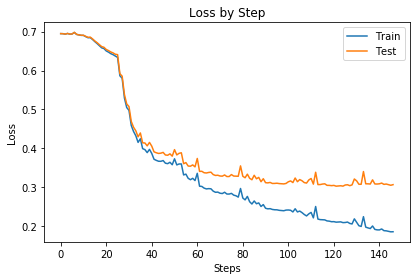

In [16]:
stats = np.array(stats)
plt.ylabel('Loss')
plt.xlabel('Steps')
plt.title('Loss by Step')
plt.tight_layout()
plt.plot(stats[:, 1], label='Train')
plt.plot(stats[:, 2], label='Test')
plt.legend()
plt.show()